# Hotel booking cancellation prediction
Authors:
* DAU Hai Dang
* Le Ha Quang
* TRAN Duc Dung

## Getting started with the RAMP starting kit

### Software prerequisites
This starting kit requires the following dependencies:

* `numpy`
* `pandas`
* `seaborn`
* `scikit-learn`
* `matplolib`
* `jupyter`

You can install all requirements with `pip install -r requirements.txt`

In addition, `ramp-workflow` is needed. This can be installed from the master branch on GitHub:

```bash
python -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master
```

### Getting the data

The public train and test data can be downloaded by running from the root of the starting kit:

```bash
python download_data.py
```

In [1]:
import numpy as np
import problem
import pandas as pd
import seaborn as sns
%matplotlib inline

## Table of content
1. [Introduction](#ph1)
2. [Exploratory Data Analysis](#ph2)
3. [Workflow](#ph3)
4. [Submission](#ph4)

## Introduction <a name="ph1"></a>

![](img/illustration_hotel_booking.jpg)

In the hospitality industry, which includes lodging, event planning, transportation, travelling or cuisine line, booking helps to provide the right product to right customer at the right time. Despite its benefits, booking cancellation option puts the services at risk. In the case of hotels, vacant capacity may happen when a guest cancel a booking or doesn't show up. While cancellations can occur due to reasonable causes like bad weather, working schedule changes, illness, etc, nowadays a great number of them happens because people search for best deals. Although, hotels can use overbooking or cancellation policy, overbooking gives a bad expericence by not allowing a customer to check in, while cancellation policy can reduce the number of bookings and reduce the income.

To overcome this problem, we propose using machine learning to predict the probility of cancellation for each reservation. This prediction helps the management decision, improve the experience of customers and the hotel's revenue. The model can be retrained regularly as the data accumulates.

### KPI and Metric

If the hotel predicts that a customer's reservation is likely to be canceled, the reception has the following solutions:
* It can either ask for more guarantee from the concerned customer, for example, by asking for a higher deposit fee.
* It can also allow other customers to be on the waitlist for the room/time slot that the likely-to-cancel customer reserved.
If the prediction is that the customer's reservation is canceled but it turns out that the customer does not cancel the reservation (false positive), there is a potential cost A for the hotel. If it demanded stricter guarantees from the customer, the customer might feel that the hotel did not trust him, especially if he is a returning customer. If it allowed other customers to be on the waitlist without finally being able to accomodate their reservations, it might create some hope, followed by ultimate frustration on these customers.

If the prediction is that the customer's reservation is not canceled but in fact it is canceled (false negative), there is a clear cost B for the hotel, because the hotel did not take any preventive actions.

From a business point of view, it is reasonable that the cost B is normally higher than the cost A. In other words, the recall score is more important than the precision score.

To reflect this, we use a Modified F1 metric (abbreviated mf1 below), where the precision's weight is 1 and the recall's weight is 3.

## Explanatory data analysis <a name="ph2"></a>

**QUANG/ DUNG:Please focus on this, important part!!!** Draw as many graphs as possible, talk as much as possible.

In [2]:
data = pd.read_csv('data/train.csv')
data.head()

,IsCanceled,LeadTime,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
0,0,187,July,28,9,2,5,2,0,0,...,A,0,No Deposit,240,NULL,0,Transient,83.00,0,2
1,1,0,September,37,9,0,1,1,0,0,...,F,0,No Deposit,NULL,NULL,0,Transient,146.00,0,2
2,1,156,September,36,2,2,5,2,0,0,...,E,0,No Deposit,171,NULL,0,Transient,98.00,0,0
3,0,5,December,51,19,0,1,2,0,0,...,D,0,No Deposit,NULL,NULL,0,Transient-Party,43.00,0,1
4,0,3,October,41,8,0,3,2,0,0,...,D,0,No Deposit,250,NULL,0,Transient,73.67,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 28 columns):
IsCanceled                     32048 non-null int64
LeadTime                       32048 non-null int64
ArrivalDateMonth               32048 non-null object
ArrivalDateWeekNumber          32048 non-null int64
ArrivalDateDayOfMonth          32048 non-null int64
StaysInWeekendNights           32048 non-null int64
StaysInWeekNights              32048 non-null int64
Adults                         32048 non-null int64
Children                       32048 non-null int64
Babies                         32048 non-null int64
Meal                           32048 non-null object
Country                        31677 non-null object
MarketSegment                  32048 non-null object
DistributionChannel            32048 non-null object
IsRepeatedGuest                32048 non-null int64
PreviousCancellations          32048 non-null int64
PreviousBookingsNotCanceled    32048 non-null int64
Re

We see that there is no missing data, except in the Country column. We can therefore fill all missing data with -1.

In [4]:
data = data.fillna(-1)

Let us now see how many categories each categorical variable has.

In [5]:
cat_cols = [col for col in data.columns if str(data[col].dtype) == 'object']
no_cats = [len(set(data[col])) for col in cat_cols]
pd.DataFrame({'Column': cat_cols, 'Number of categories': no_cats})

,Column,Number of categories
0,ArrivalDateMonth,12
1,Meal,5
2,Country,118
3,MarketSegment,6
4,DistributionChannel,4
5,ReservedRoomType,10
6,AssignedRoomType,11
7,DepositType,3
8,Agent,178
9,Company,226


For numerical or binary variables, the **describe** function provides valuable insights.

In [6]:
data.describe()

,IsCanceled,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000,32048.000000
mean,0.276804,92.450012,27.088492,15.802733,1.186252,3.124282,1.866232,0.128838,0.013885,0.044496,0.099663,0.150743,0.289066,0.525119,95.043906,0.138698,0.618198
std,0.447426,97.066314,13.978094,8.892396,1.143512,2.444580,0.683958,0.444471,0.118869,0.206197,1.325955,1.027454,0.727221,7.388141,61.556252,0.352785,0.813272
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,10.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,0.000000,57.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,0.000000
75%,1.000000,154.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000,1.000000
max,1.000000,737.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,2.000000,1.000000,26.000000,28.000000,17.000000,185.000000,450.000000,8.000000,5.000000


Some first observations:
* The problem is imbalanced (because mean of IsCanceled is 0.28). This is confirmed by the plot below
* This hotel is very busy. Mean of LeadTime is 92.5, which means that most bookings take place in average 90 days before arrival time. This makes cancellation prediction problem very important from a business point of view.
* Mean of IsRepeatedGuest is 0.04, so most guests are in fact new ones. Again, this means that cancellation prediction is an important problem for this hotel.

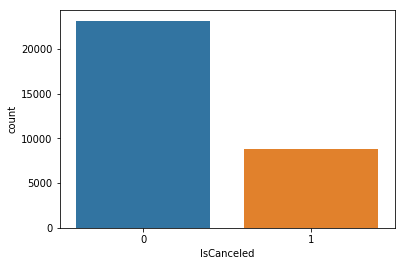

In [7]:
sns.countplot(x = 'IsCanceled', data = data)

## Workflow <a name="ph3"></a>

The workflow is: Feature Extractor + Classifier. [QUANG/DUNG :add a picture of the workflow here].

The difficulty is that there are categorical variables, and each subset of the train set (that is created for example by the cross validation procedure) may not contain all the categories of a categorical variables. The challenge is thus to write a **transform** function which produces an array of consistent sizes, even if **transform** is applied to a subset of the train set. One way to deal with this problem is to consider missing values as a category, and then consider all new categorical values in the test set as missing values. Here **transform** converts all categorical variables' types into pandas categorical type.

QUANG/DUNG: If you have time, please write a less stupid feature_extractor and classifier. Do not change the starting_kit but rather create a new kit.

In [8]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd
class FeatureExtractor:
    def __init__(self):
        pass
    
    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):
        # Handle mising data
        X_df_2 = X_df.fillna(-1)
        
        # Transform categorical features into pandas's categorical type
        non_numeric_columns = ['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 
                               'ReservedRoomType', 'AssignedRoomType', 'DepositType', 'Agent', 'Company', 
                               'CustomerType']
        X_df_2[non_numeric_columns] = X_df_2[non_numeric_columns].astype('category')
        
        return X_df_2

Overwriting submissions/starting_kit/feature_extractor.py


In [9]:
%%file submissions/starting_kit/classifier.py
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import numpy as np

class Classifier(BaseEstimator):
    def __init__(self):
        self.model = make_pipeline(StandardScaler(), LogisticRegression())
    
    def fit(self, X, y):
        
        # Train using traditional Gradient Boosting Decision Tree (of lightgbm package)
        # Train data set
        train_data = lgb.Dataset(X, label=y) 
        
        # Parameters
        param = {'boosting':'gbdt', 'num_leaves':31, 'objective':'binary',
            'learning_rate':.05, 'max_bin':255, 'min_data_in_leaf':100,
            'bagging_freq':1, 'bagging_fraction':1., 'lambda_l1':1, 'lambda_l2':1,
            'verbose':-1}
        param['metric'] = 'binary_logloss'
        
        num_round = 600
        
        # Train
        self.model = lgb.train(param, train_data, num_round)
        
    def predict_proba(self, X):
        pred = self.model.predict(X)
        return np.array([1 - pred, pred]).T

Overwriting submissions/starting_kit/classifier.py


## Submission <a name="ph4"></a>

In [10]:
!ramp_test_submission --submission starting_kit

Testing Hotel booking cancellation prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.82  0.83  0.82
	test   0.82  0.84  0.81
CV fold 1
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.80  0.84  0.79
	test   0.81  0.83  0.81
CV fold 2
	score   mf1  prec   rec
	train  0.91  0.92  0.90
	valid  0.81  0.84  0.79
	test   0.82  0.84  0.81
CV fold 3
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.80  0.83  0.79
	test   0.82  0.84  0.81
CV fold 4
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.80  0.84  0.78
	test   0.81  0.84  0.81
CV fold 5
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.80  0.82  0.79
	test   0.82  0.84  0.81
CV fold 6
	score   mf1  prec   rec
	train  0.91  0.92  0.90
	valid  0.80  0.82  0.79
	test   0.82  0.84  0.81
CV fold 7
	score   mf1  prec   rec
	train  0.90  0.92  0.90
	valid  0.81  0.82  0.80
	